In [1]:
# Cell 1/5: imports, caminhos e funções auxiliares
from pathlib import Path
import pandas as pd
import re, unicodedata
import matplotlib.pyplot as plt

# ---------- AJUSTE AQUI se necessário ----------
file_ia    = Path("../database/Projetos de Atuação - IA - 2020 a 2025.xlsx")
file_dtb   = Path("../database/RELATORIO_DTB_BRASIL_2024_MUNICIPIOS.xls")  # sua função getdtb usa esse arquivo
# (o IDEB será procurado automaticamente na célula 3)
# ----------------------------------------------

def normalizar_texto(s):
    if pd.isna(s): return ""
    s = str(s)
    s = unicodedata.normalize('NFKD', s)
    s = ''.join(ch for ch in s if not unicodedata.combining(ch))
    return s.strip()

def to_ibge_str(x):
    """Converte/Clean código IBGE para string 7 dígitos (remove .0, não dígitos e zfill)."""
    if pd.isna(x): return None
    s = str(x).strip()
    s = re.sub(r'\.0+$','', s)      # remove .0 final
    s = re.sub(r'\D', '', s)        # keep digits only
    return s.zfill(7) if s else None

def detect_header_row(path, keywords=('CIDADES','UF')):
    """Procura linha de header lendo as primeiras 20 linhas (retorna None se não achar)."""
    preview = pd.read_excel(path, header=None, nrows=20)
    header_row = None
    for i in range(len(preview)):
        row = preview.iloc[i].astype(str).str.upper().tolist()
        if all(any(k in cell for cell in row) for k in keywords):
            header_row = i
            break
    return header_row


In [2]:
# Cell 2/5: leitura e extração das colunas finais (nprojetos, ninstituicoes, nbeneficiados) para 2020-2025

if not file_ia.exists():
    raise FileNotFoundError(f"Arquivo IA não encontrado: {file_ia}")

anos = [str(y) for y in range(2020, 2026)]
rows = []

def choose_trio_final(cols):
    """Heurística simples: procura colunas contendo 'Projet', 'Institu' e 'Benefici' e retorna os últimos encontrados."""
    proj = [c for c in cols if re.search(r'projet', str(c), flags=re.I)]
    inst = [c for c in cols if re.search(r'institu|escol', str(c), flags=re.I)]
    ben  = [c for c in cols if re.search(r'benefici|particip', str(c), flags=re.I)]
    return (proj[-1] if proj else None,
            inst[-1] if inst else None,
            ben[-1] if ben else None)

for ano in anos:
    if ano not in pd.ExcelFile(file_ia).sheet_names:
        continue
    
    # tentar detectar header
    header_row = detect_header_row(file_ia)
    if header_row is None:
        # fallback comum
        df = pd.read_excel(file_ia, sheet_name=ano, skiprows=5, dtype=object)
    else:
        df = pd.read_excel(file_ia, sheet_name=ano, header=header_row, dtype=object)
    
    # limpar colunas Unnamed e colunas totalmente vazias
    df = df.loc[:, ~df.columns.astype(str).str.contains('^Unnamed', na=False)]
    df = df.dropna(axis=1, how='all')
    cols = list(df.columns)
    
    # identificar colunas cidade/uf e trio final
    city_col = next((c for c in cols if re.search(r'cidad|municip|cidades', str(c), flags=re.I)), None)
    uf_col = next((c for c in cols if re.search(r'^\s*uf\s*$|estado', str(c), flags=re.I)), None)
    proj_col, inst_col, ben_col = choose_trio_final(cols)
    
    # montar dataframe reduzido
    sel = pd.DataFrame()

    if city_col: sel['ds_mun'] = df[city_col].astype(str).str.strip()
    if uf_col: sel['sg_uf'] = df[uf_col].astype(str).str.strip()
    if proj_col: sel['nprojetos'] = pd.to_numeric(df[proj_col], errors='coerce')
    if inst_col: sel['ninstituicoes'] = pd.to_numeric(df[inst_col], errors='coerce')
    if ben_col: sel['nbeneficiados'] = pd.to_numeric(df[ben_col], errors='coerce')
    
    sel['ano'] = int(ano)
    rows.append(sel)

if not rows:
    raise RuntimeError("Não li nenhuma aba 2020-2025 do arquivo IA. Verifique as abas/nomes.")

data_ia = pd.concat(rows, ignore_index=True, sort=False)

# padronizações simples
data_ia['ds_mun'] = data_ia['ds_mun'].astype(str).str.strip()
data_ia['ds_norm'] = data_ia['ds_mun'].map(lambda x: normalizar_texto(x).upper().replace(" ", "") if pd.notna(x) else "")
print("Linhas IA consolidadas:", len(data_ia))
display(data_ia.head(5))


Linhas IA consolidadas: 135


,ds_mun,sg_uf,nprojetos,ninstituicoes,nbeneficiados,ano,ds_norm
0,ALAGOA NOVA,PB,3.0,72.0,5096.0,2020,ALAGOANOVA
1,BANANEIRAS,PB,3.0,2.0,518.0,2020,BANANEIRAS
2,CAMPINA GRANDE,PB,9.0,336.0,59226.0,2020,CAMPINAGRANDE
3,CARPINA,PE,3.0,36.0,14180.0,2020,CARPINA
4,GUARABIRA,PB,4.0,68.0,10574.0,2020,GUARABIRA


In [3]:
# Cell 3/5: usar DTB para imputar id_mundv por município + UF
# tenta usar getdtb (se existir no seu projeto), senão lê o arquivo DTB diretamente assumindo col ds_mun e uf

try:
    from utils import getdtb
    df_dtb = getdtb(file_dtb)
except Exception:
    if not file_dtb.exists():
        raise FileNotFoundError(f"DTB não encontrada: {file_dtb}. Para imputar id_mundv é necessário o DTB.")
    # leitura simples (ajuste se seu DTB for .xls)
    df_dtb = pd.read_excel(file_dtb, dtype=object)

# padronizar dtb
df_dtb['ds_mun'] = df_dtb['ds_mun'].astype(str).str.strip()
df_dtb['ds_norm'] = df_dtb['ds_mun'].map(lambda x: normalizar_texto(x).upper().replace(" ", ""))

# mapear UF long name (se precisar): assumimos coluna ds_uf em IA (ex.: 'Paraíba')
# preparar data_ia para merge: criar ds_formatada e ds_uf com nomes longos se user tiver somente sigla
data_ia['ds_formatada'] = data_ia['ds_norm']

# se IA tem sg_uf e precisa mapear para nomes completos, ajuste aqui:
uf_map_exemplo = {"PB":"Paraíba","PE":"Pernambuco","MG":"Minas Gerais","SP":"São Paulo"}

if 'sg_uf' in data_ia.columns:
    # se sg_uf já for sigla, tentar mapear; senão assumir já é o nome
    data_ia['ds_uf'] = data_ia['sg_uf'].map(lambda s: uf_map_exemplo.get(str(s).strip(), str(s).strip()))
else:
    data_ia['ds_uf'] = None

# Fazer merge: tentamos com ds_formatada + ds_uf quando ds_uf não for nulo, senão apenas pelo nome
def merge_with_dtb(dfia, dtdf):
    if dfia['ds_uf'].notna().any():
        m = dfia.merge(dtdf, left_on=['ds_formatada','ds_uf'], right_on=['ds_norm','ds_uf'], how='left', suffixes=('_ia',''))
        # se muitos missings, tentar apenas por nome
        if m['id_mundv'].isna().sum() > 0:
            m2 = dfia.merge(dtdf, left_on='ds_formatada', right_on='ds_norm', how='left', suffixes=('_ia',''))
            # preencher id_mundv onde possível
            m['id_mundv'] = m['id_mundv'].fillna(m2['id_mundv'])
            return m
        return m
    else:
        return dfia.merge(dtdf, left_on='ds_formatada', right_on='ds_norm', how='left', suffixes=('_ia',''))

data_m = merge_with_dtb(data_ia, df_dtb)

# padronizar id_mundv numeric
data_m['id_mundv'] = pd.to_numeric(data_m.get('id_mundv', None), errors='coerce').astype('Int64')
print("Após merge DTB: registros com id_mundv preenchido:", data_m['id_mundv'].notna().sum(), "de", len(data_m))
display(data_m[['ds_mun','ds_uf','id_mundv']].drop_duplicates().head(5))


INSPEÇÃO PRIMEIRAS LINHAS
 -------------------- 

    id_uf     ds_uf     ds_rgi  id_mundv                   ds_mun
0     11  Rondônia     Cacoal   1100015    Alta Floresta D'Oeste
1     11  Rondônia     Cacoal   1100379  Alto Alegre dos Parecis
2     11  Rondônia  Ariquemes   1100403             Alto Paraíso
3     11  Rondônia  Ji-Paraná   1100346         Alvorada D'Oeste
4     11  Rondônia  Ariquemes   1100023                Ariquemes
INSPEÇÃO ULTIMAS LINHAS 

       id_uf             ds_uf                      ds_rgi  id_mundv  \
5566     52             Goiás                    Anápolis   5222005   
5567     52             Goiás                 Piracanjuba   5222054   
5568     52             Goiás             Flores de Goiás   5222203   
5569     52             Goiás  Ceres - Rialma - Goianésia   5222302   
5570     53  Distrito Federal            Distrito Federal   5300108   

              ds_mun  
5566      Vianópolis  
5567  Vicentinópolis  
5568        Vila Boa  
5569   Vila P

,ds_mun,ds_uf,id_mundv
0,Alagoa Nova,Paraíba,2500403
1,Bananeiras,Paraíba,2501500
2,Campina Grande,Paraíba,2504009
3,Carpina,Pernambuco,2604007
4,Guarabira,Paraíba,2506301


In [4]:
# Cell 4/5: localizar arquivo IDEB automaticamente, ler, transformar e pivot (id_mundv x anos)
from pathlib import Path

file_ideb = Path("../database/divulgacao_anos_iniciais_municipios_2023.xlsx")

candidates = [file_ideb] if file_ideb.exists() else []

if not candidates:
    raise FileNotFoundError(f"Arquivo IDEB não encontrado em {file_ideb}.")
else:
    print(f"Arquivo IDEB localizado em: {file_ideb}")
    
file_ideb = candidates[0]
print("Usando IDEB:", file_ideb)

# detectar header e ler (fallback skiprows=9)
def read_ideb(path):
    try:
        df = pd.read_excel(path, skiprows=9)
        if any(re.search(r'CO[_ ]*MUNICIP', str(c), flags=re.I) for c in df.columns):
            return df
    except Exception:
        pass
    raw = pd.read_excel(path, header=None, nrows=20)
    header_row = None
    for i in range(len(raw)):
        rowtext = " ".join(raw.iloc[i].astype(str).str.lower().tolist())
        if 'co_municipio' in rowtext or 'co municipio' in rowtext:
            header_row = i
            break
    if header_row is None:
        header_row = 9
    df = pd.read_excel(path, skiprows=header_row)
    return df

ideb_raw = read_ideb(file_ideb)

# detectar coluna código e colunas de ano
code_col = next((c for c in ideb_raw.columns if re.search(r'CO[_ ]*MUNICIP', str(c), flags=re.I)), None)
if code_col is None:
    raise RuntimeError("Não detectei coluna CO_MUNICIPIO no IDEB lido. Abra o arquivo e verifique header.")

# localizar colunas com anos (VL_OBSERVADO_YYYY ou colunas contendo 4 dígitos)
year_cols = [c for c in ideb_raw.columns if re.search(r'VL_OBSERVADO_\d{4}', str(c), flags=re.I)]

if not year_cols:
    year_cols = [c for c in ideb_raw.columns if re.search(r'\b(2016|2017|2018|2019|2020|2021|2022|2023|2024|2025)\b', str(c))]
if not year_cols:
    raise RuntimeError("Não detectei colunas de ano no IDEB.")

# construir long
name_col = next((c for c in ideb_raw.columns if re.search(r'municip', str(c), flags=re.I) and c != code_col), None)
usecols = [code_col] + ([name_col] if name_col else []) + year_cols
ideb = ideb_raw[usecols].rename(columns={code_col:'id_mundv', name_col:'mun_name'} if name_col else {code_col:'id_mundv'})

# renomear year_cols -> ideb_YYYY e melt
colmap = {}
for c in year_cols:
    m = re.search(r'(\d{4})', str(c))
    yr = m.group(1) if m else str(c)
    colmap[c] = f'ideb_{yr}'
ideb = ideb.rename(columns=colmap)
ideb_year_cols = [colmap[c] for c in year_cols]
ideb_long = ideb.melt(id_vars=[c for c in ['id_mundv','mun_name'] if c in ideb.columns],
                      value_vars=ideb_year_cols, var_name='ano_col', value_name='valor_ideb')
ideb_long['ano'] = ideb_long['ano_col'].str.extract(r'(\d{4})')[0].astype('Int64')
ideb_long['valor_ideb'] = pd.to_numeric(ideb_long['valor_ideb'], errors='coerce')

# normalizar id para string 7 e numérico
ideb_long['id_str7'] = ideb_long['id_mundv'].astype(str).str.replace(r'\.0+$','', regex=True).str.zfill(7)
ideb_long['id_num'] = pd.to_numeric(ideb_long['id_mundv'], errors='coerce').astype('Int64')

# --------------- Merge por id (numérico preferencial) ---------------
# preparar lista de munis do Instituto (id numérico e id_str7)
munis = data_m[['id_mundv','ds_mun']].drop_duplicates()
munis['id_num'] = pd.to_numeric(munis['id_mundv'], errors='coerce').astype('Int64')
munis['id_str7'] = munis['id_mundv'].astype(str).str.replace(r'\.0+$','', regex=True).str.zfill(7)

# merge numérico
merged_num = munis.merge(ideb_long[['id_num','ano','valor_ideb']], left_on='id_num', right_on='id_num', how='left')
# pivot (id_num x anos)
pivot = merged_num.pivot_table(index=['id_num','ds_mun'], columns='ano', values='valor_ideb', aggfunc='first').reset_index()
pivot.columns.name = None

# se muitos NaNs (poucos matches), tentar fallback por id_str7
matches_numeric = merged_num.groupby('id_num').apply(lambda g: g['valor_ideb'].notna().any()).sum()
if matches_numeric < len(munis):
    merged_str = munis.merge(ideb_long[['id_str7','ano','valor_ideb']], left_on='id_str7', right_on='id_str7', how='left')
    pivot_str = merged_str.pivot_table(index=['id_str7','ds_mun','id_num'], columns='ano', values='valor_ideb', aggfunc='first').reset_index()
    # preferir pivot_str se aumentou matches
    matches_str = merged_str.groupby('id_str7').apply(lambda g: g['valor_ideb'].notna().any()).sum()
    if matches_str > matches_numeric:
        # reorganiza para id_num, ds_mun, anos
        pivot = pivot_str.copy()
        # garantir colunas coerentes
        if 'id_num' not in pivot.columns:
            pivot['id_num'] = pivot['id_str7'].astype(str).str.lstrip('0').replace('', pd.NA).astype('Int64')
        pivot = pivot.rename(columns={'id_num':'id_num'})  # keep
print("Tabela pivot (amostra):")
display(pivot.head(5))


Arquivo IDEB localizado em: ../database/divulgacao_anos_iniciais_municipios_2023.xlsx
Usando IDEB: ../database/divulgacao_anos_iniciais_municipios_2023.xlsx
Tabela pivot (amostra):


/tmp/ipykernel_2216/1207644993.py:86: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  matches_numeric = merged_num.groupby('id_num').apply(lambda g: g['valor_ideb'].notna().any()).sum()
/tmp/ipykernel_2216/1207644993.py:91: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  matches_str = merged_str.groupby('id_str7').apply(lambda g: g['valor_ideb'].notna().any()).sum()


,id_num,ds_mun,2005,2007,2009,2011,2013,2015,2017,2019,2021,2023
0,2500403,Alagoa Nova,3.4,4.3,4.0,3.9,5.2,5.0,5.4,5.7,5.1,5.7
1,2501401,Baía da Traição,2.6,3.1,2.8,4.6,4.3,4.5,3.8,4.1,NaN,NaN
2,2501500,Bananeiras,3.4,3.7,3.9,4.2,4.5,4.5,3.8,4.9,4.9,4.7
3,2503100,Cabaceiras,2.6,3.4,4.9,5.4,5.6,6.0,6.4,6.1,6.6,7.7
4,2504009,Campina Grande,3.3,3.7,4.0,4.4,4.4,4.6,5.1,6.1,5.6,5.7


Resultado final — linhas: 18 colunas (anos): [2005, 2007, 2009, 2011, 2013, 2015, 2017, 2019, 2021, 2023]


,id_mundv,ds_mun,2005,2007,2009,2011,2013,2015,2017,2019,2021,2023
0,2500403,Alagoa Nova,3.4,4.3,4.0,3.9,5.2,5.0,5.4,5.7,5.1,5.7
1,2501401,Baía da Traição,2.6,3.1,2.8,4.6,4.3,4.5,3.8,4.1,NaN,NaN
2,2501500,Bananeiras,3.4,3.7,3.9,4.2,4.5,4.5,3.8,4.9,4.9,4.7
3,2503100,Cabaceiras,2.6,3.4,4.9,5.4,5.6,6.0,6.4,6.1,6.6,7.7
4,2504009,Campina Grande,3.3,3.7,4.0,4.4,4.4,4.6,5.1,6.1,5.6,5.7
5,2504355,Caturité,3.2,3.0,4.1,3.7,3.5,4.1,4.8,4.4,NaN,5.3
6,2506301,Guarabira,3.0,3.5,3.5,3.8,3.9,4.6,4.4,4.2,4.8,5.1
7,2506806,Ingá,2.5,3.2,3.1,3.3,3.3,4.1,4.0,3.1,3.9,5.0
8,2507200,Itatuba,2.4,3.4,2.3,3.7,3.5,4.0,3.9,4.5,4.4,4.5
9,2507507,João Pessoa,3.3,3.5,3.8,4.1,4.4,4.6,6.6,5.0,5.3,5.0


Salvo em: /home/ryannfelix/Downloads/ideb_municipios_instituto_por_id.csv


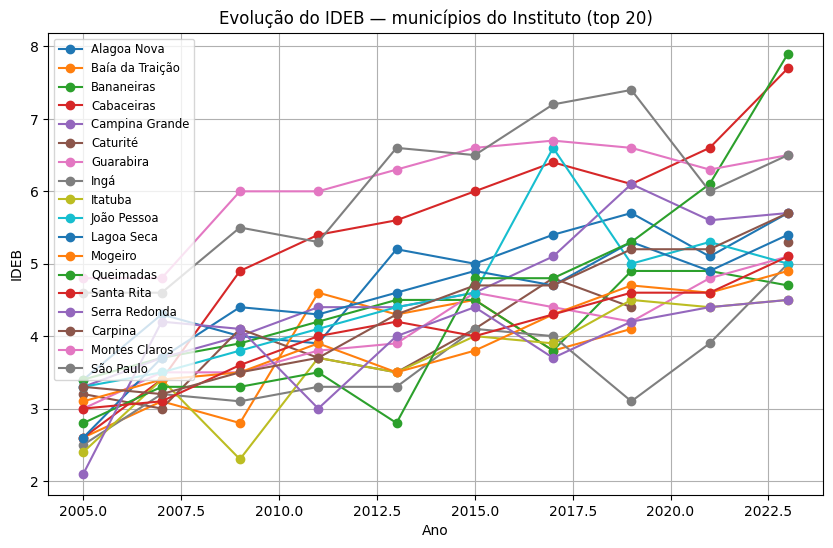

In [5]:
# Cell 5/5: organizar, salvar CSV e plot básico

# reorganizar colunas: id_mundv (num), ds_mun, anos ordenados
if 'id_num' in pivot.columns:
    pivot = pivot.rename(columns={'id_num':'id_mundv'}).set_index('id_mundv')
else:
    # tentar coluna com index que represente o id
    idx_col = next((c for c in pivot.columns if re.search(r'id', str(c), flags=re.I)), None)
    if idx_col and idx_col != 'ds_mun':
        pivot = pivot.set_index(idx_col)
pivot = pivot.reset_index()

# identificar anos nas colunas
year_cols = [c for c in pivot.columns if isinstance(c, int) or (isinstance(c,str) and re.fullmatch(r'\d{4}', str(c)))]

# garantir ordenação e tipos
year_cols = sorted([int(c) for c in year_cols])

# reorganizar
cols = [c for c in ['id_mundv','ds_mun'] if c in pivot.columns] + [c for c in year_cols if c in pivot.columns]
result = pivot[[c for c in cols if c in pivot.columns]].copy()

# renomear colunas de ano como inteiros (caso estejam strings)
result.columns = [int(c) if re.fullmatch(r'\d{4}', str(c)) else c for c in result.columns]

# exibir e salvar
print("Resultado final — linhas:", len(result), "colunas (anos):", [c for c in result.columns if isinstance(c,int)])
display(result)

out = Path.home() / "Downloads" / "ideb_municipios_instituto_por_id.csv"
result.to_csv(out, index=False)
print("Salvo em:", out)

# plot simples (uma linha por município; se muitas linhas, mostrar apenas Top N)
top_n = 20
to_plot = result.head(top_n)  # ajuste se quiser selecionar por nbeneficiados
if not any(isinstance(c, int) for c in to_plot.columns):
    print("Nenhuma coluna de ano detectada para plotagem.")
else:
    plt.figure(figsize=(10,6))
    years = [c for c in to_plot.columns if isinstance(c,int)]
    for _, r in to_plot.iterrows():
        vals = [r.get(y, pd.NA) for y in years]
        if pd.Series(vals).dropna().empty: continue
        plt.plot(years, vals, marker='o', label=f"{r.get('ds_mun','id_'+str(r['id_mundv']))}")
    plt.xlabel("Ano"); plt.ylabel("IDEB"); plt.title("Evolução do IDEB — municípios do Instituto (top {})".format(top_n))
    plt.grid(True)
    if len(to_plot)<=25: plt.legend(fontsize='small')
    plt.show()


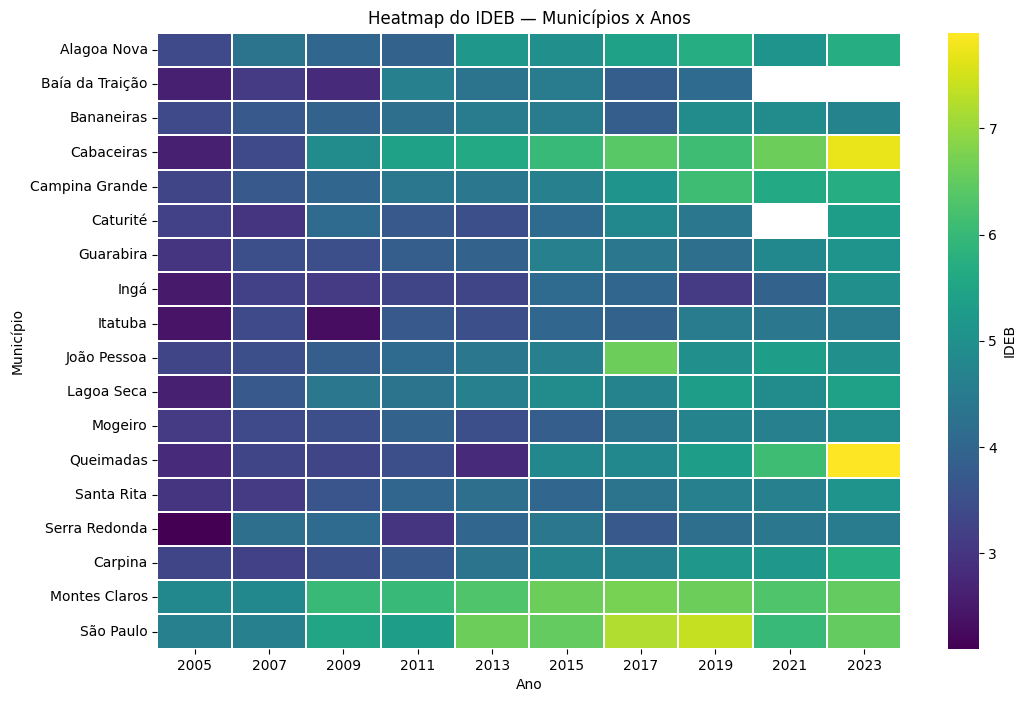

In [7]:
import seaborn as sns

plt.figure(figsize=(12,8))
sns.heatmap(
    result.set_index("ds_mun")[years], 
    cmap="viridis", 
    cbar_kws={'label': 'IDEB'},
    linewidths=0.1
)
plt.title("Heatmap do IDEB — Municípios x Anos")
plt.xlabel("Ano")
plt.ylabel("Município")
plt.show()


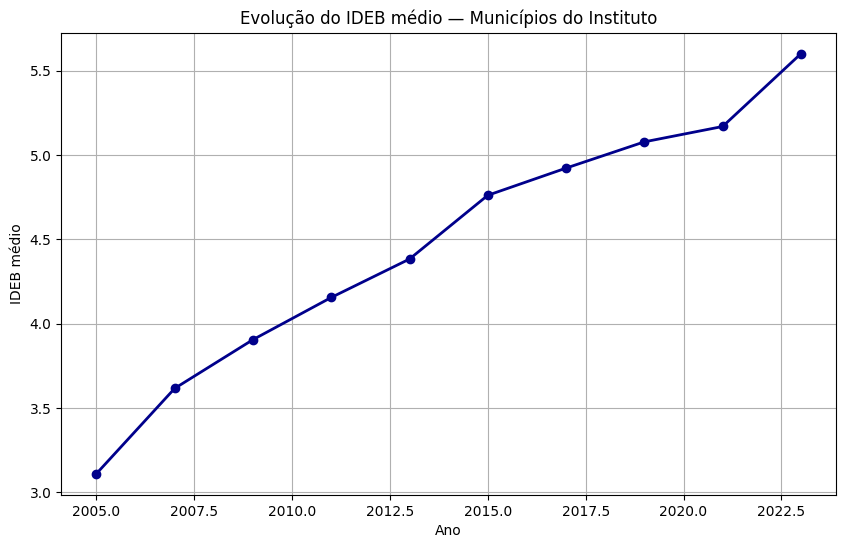

In [8]:
plt.figure(figsize=(10,6))
mean_vals = result[years].mean()
plt.plot(years, mean_vals, marker='o', linewidth=2, color="darkblue")
plt.xlabel("Ano"); plt.ylabel("IDEB médio")
plt.title("Evolução do IDEB médio — Municípios do Instituto")
plt.grid(True)
plt.show()


/tmp/ipykernel_2216/2025614938.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=rank.head(15), x=last_year, y="ds_mun", palette="Blues_r")


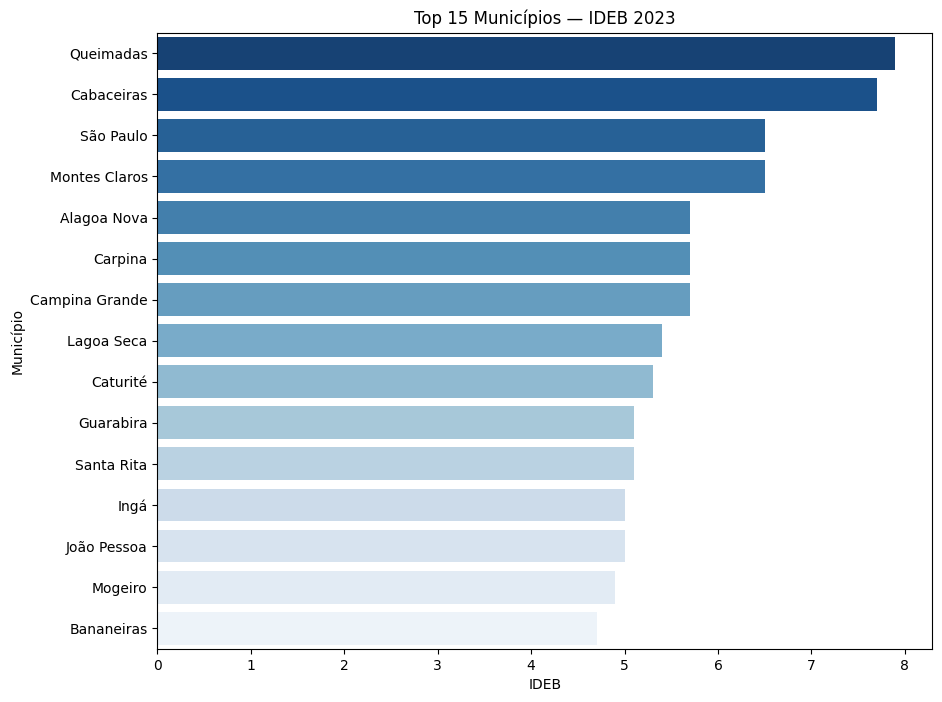

In [9]:
last_year = max(years)
rank = result[['ds_mun', last_year]].dropna().sort_values(last_year, ascending=False)

plt.figure(figsize=(10,8))
sns.barplot(data=rank.head(15), x=last_year, y="ds_mun", palette="Blues_r")
plt.title(f"Top 15 Municípios — IDEB {last_year}")
plt.xlabel("IDEB")
plt.ylabel("Município")
plt.show()


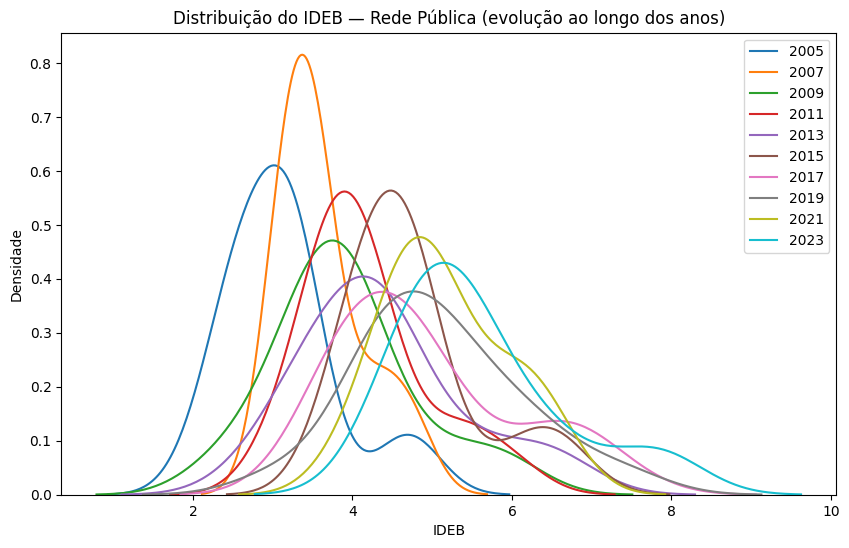

In [23]:
plt.figure(figsize=(10,6))
for y in years:
    sns.kdeplot(result[y].dropna(), label=str(y))
plt.xlabel("IDEB")
plt.ylabel("Densidade")
plt.title("Distribuição do IDEB — Rede Pública (evolução ao longo dos anos)")
plt.legend()
plt.show()


/tmp/ipykernel_2216/1199697399.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=rank_delta.head(15), x="delta", y="ds_mun", palette="Greens")


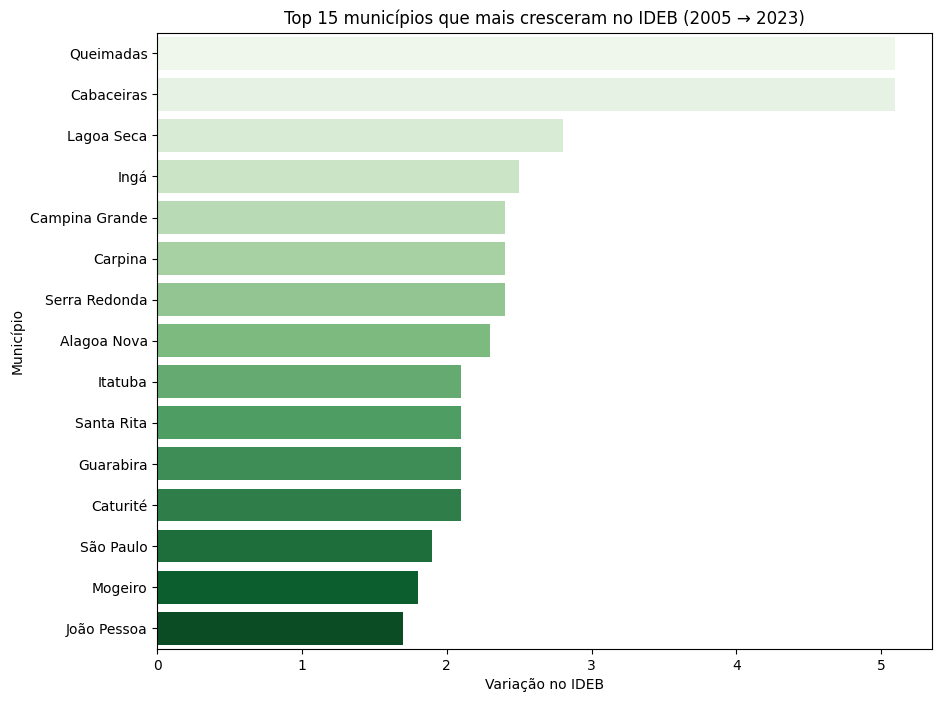

In [26]:
delta = result[end] - result[start]
rank_delta = pd.DataFrame({"ds_mun": result["ds_mun"], "delta": delta}).dropna()
rank_delta = rank_delta.sort_values("delta", ascending=False)

plt.figure(figsize=(10,8))
sns.barplot(data=rank_delta.head(15), x="delta", y="ds_mun", palette="Greens")
plt.title(f"Top 15 municípios que mais cresceram no IDEB ({start} → {end})")
plt.xlabel("Variação no IDEB")
plt.ylabel("Município")
plt.show()
